In [2]:
#import neg_score and pos_score
import pickle
import numpy as np
import matplotlib.pyplot as plt
# run_name =  'rm_hh_rlhf_202411100543'
from gpt import GPT, GPTRewardModel
from configs import get_configs
from dataset import StepDPODataset
import torch
from loss import KPairwiseLoss, CrossEntropyLoss, ValueLoss, PolicyLoss
import statistics

c:\Users\pc\.conda\envs\hoang\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\pc\.conda\envs\hoang\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\pc\.conda\envs\hoang\lib\site-packages\torchvision\transforms\v2\__init__

In [3]:
cfg = get_configs('gpt2-medium')

In [5]:
opt_model = GPTRewardModel.from_checkpoint(cfg, r'runs\rm_metamath_202412220401\rm_metamath_202412220401_step8367.pt')

In [6]:

test_ds =  StepDPODataset(block_size=1024,
                                     split='test',
                                     max_examples=None,
                                     tokenizer_name="tiktoken/gpt2")

In [9]:
from torch.utils.data import DataLoader

In [20]:
test_dataloader = DataLoader(test_ds,
                                           4,
                                           
                                           pin_memory=True)

In [23]:
run_name = r'rm_metamath_202412220401'
device = "cuda"
epoch = 0

In [17]:
criterion = KPairwiseLoss()
opt_model.to(device)

GPTRewardModel(
  (backbone): GPT(
    (transformer): TransformerDecoder(
      (token_embedding_layer): Embedding(50257, 1024)
      (postion_embedding_layer): Embedding(1024, 1024)
      (input_dropout): Dropout(p=0, inplace=False)
      (decoder_blocks): ModuleList(
        (0-23): 24 x TransformerDecoderBlock(
          (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mmsa): MaskedMultiheadSelfAttention(
            (qkv_projection): Linear(in_features=1024, out_features=3072, bias=True)
            (output_projection): Linear(in_features=1024, out_features=1024, bias=True)
            (attention_dropout): Dropout(p=0, inplace=False)
            (output_dropout): Dropout(p=0, inplace=False)
          )
          (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (ffn): FeedForwardNetworks(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  

In [21]:
from tqdm import tqdm

In [24]:
if True:
                pos_scores = []
                neg_scores = []
                opt_model.eval()
                with torch.no_grad():
                    tp = 0
                    total = 0
                    losses = []
                    for step, (completions, attention_masks) in tqdm(enumerate(
                        test_dataloader)):
                        completions = completions.to(device)
                        attention_masks = attention_masks.to(device)

                        positive_scores = opt_model(
                            completions[:, 0, :],
                            attention_masks[:, 0, :])  # (B, 1)
                        pos_scores.extend(positive_scores)
                        negative_scores = opt_model(
                            completions[:, 1, :],
                            attention_masks[:, 1, :])  # (B, 1)
                        neg_scores.extend(negative_scores)
                        loss = criterion(
                            torch.cat((positive_scores, negative_scores),
                                      dim=-1))  # (B, 2)
                        lossf = loss.item()
                        losses.append(lossf)
                        
                        tp += torch.count_nonzero(
                            positive_scores > negative_scores)
                        total += positive_scores.shape[0]

                    acc = tp / total
                    epoch_loss = statistics.mean(losses)
                neg_scores_cpu = [score.cpu().numpy() for score in neg_scores]  
# Flatten the list of NumPy arrays into a single 1D array
                neg_scores_cpu = np.concatenate(neg_scores_cpu) 
                pos_scores_cpu = [score.cpu().numpy() for score in pos_scores]  
                pos_scores_cpu = np.concatenate(pos_scores_cpu)
                
                
                with open(f'./runs/{run_name}/neg_scores_{epoch}.pkl', 'wb') as f:
                  pickle.dump(neg_scores_cpu, f)
                with open(f'./runs/{run_name}/pos_scores_{epoch}.pkl', 'wb') as f:
                   pickle.dump(pos_scores_cpu, f)

370it [03:42,  1.66it/s]


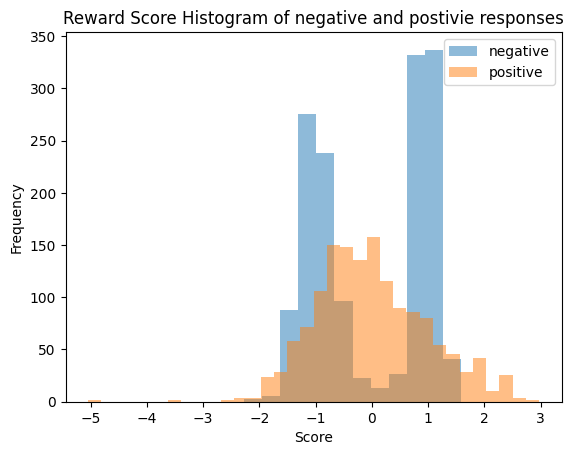

In [4]:
run_name = r'runs\rm_metamath_202412220401\rm_metamath_202412220401_step8367.pt'
run_name = run_name[:run_name.rindex('\\')]
epoch = 0
neg_scores_cpu = pickle.load(open(f'{run_name}/neg_scores_{epoch}.pkl', 'rb'))
pos_scores_cpu = pickle.load(open(f'{run_name}/pos_scores_{epoch}.pkl', 'rb'))
#normalize
neg_scores_cpu = (neg_scores_cpu - np.mean(neg_scores_cpu)) / np.std(neg_scores_cpu)
pos_scores_cpu = (pos_scores_cpu - np.mean(pos_scores_cpu)) / np.std(pos_scores_cpu)
import matplotlib.pyplot as plt
plt.hist(neg_scores_cpu, bins='auto', alpha=0.5, label='negative')
plt.hist(pos_scores_cpu, bins='auto', alpha=0.5, label='positive')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Reward Score Histogram of negative and postivie responses')
plt.legend(loc='upper right')
plt.show()

In [6]:
mean = (np.sum(neg_scores_cpu) + np.sum(pos_scores_cpu))/(len(neg_scores_cpu) + len(pos_scores_cpu))
std = np.sqrt((np.sum((neg_scores_cpu - mean)**2) + np.sum((pos_scores_cpu - mean)**2))/(len(neg_scores_cpu) + len(pos_scores_cpu)))

In [13]:
rm = GPT.from_checkpoint(cfg, r'rm_Math_not_SFT_202412190947\rm_Math_not_SFT_202412190947_step6881.pt')

RuntimeError: Error(s) in loading state_dict for GPT:
	Missing key(s) in state_dict: "transformer.token_embedding_layer.weight", "transformer.postion_embedding_layer.weight", "transformer.decoder_blocks.0.ln1.weight", "transformer.decoder_blocks.0.ln1.bias", "transformer.decoder_blocks.0.mmsa.mask", "transformer.decoder_blocks.0.mmsa.qkv_projection.weight", "transformer.decoder_blocks.0.mmsa.qkv_projection.bias", "transformer.decoder_blocks.0.mmsa.output_projection.weight", "transformer.decoder_blocks.0.mmsa.output_projection.bias", "transformer.decoder_blocks.0.ln2.weight", "transformer.decoder_blocks.0.ln2.bias", "transformer.decoder_blocks.0.ffn.fc1.weight", "transformer.decoder_blocks.0.ffn.fc1.bias", "transformer.decoder_blocks.0.ffn.fc2.weight", "transformer.decoder_blocks.0.ffn.fc2.bias", "transformer.decoder_blocks.1.ln1.weight", "transformer.decoder_blocks.1.ln1.bias", "transformer.decoder_blocks.1.mmsa.mask", "transformer.decoder_blocks.1.mmsa.qkv_projection.weight", "transformer.decoder_blocks.1.mmsa.qkv_projection.bias", "transformer.decoder_blocks.1.mmsa.output_projection.weight", "transformer.decoder_blocks.1.mmsa.output_projection.bias", "transformer.decoder_blocks.1.ln2.weight", "transformer.decoder_blocks.1.ln2.bias", "transformer.decoder_blocks.1.ffn.fc1.weight", "transformer.decoder_blocks.1.ffn.fc1.bias", "transformer.decoder_blocks.1.ffn.fc2.weight", "transformer.decoder_blocks.1.ffn.fc2.bias", "transformer.decoder_blocks.2.ln1.weight", "transformer.decoder_blocks.2.ln1.bias", "transformer.decoder_blocks.2.mmsa.mask", "transformer.decoder_blocks.2.mmsa.qkv_projection.weight", "transformer.decoder_blocks.2.mmsa.qkv_projection.bias", "transformer.decoder_blocks.2.mmsa.output_projection.weight", "transformer.decoder_blocks.2.mmsa.output_projection.bias", "transformer.decoder_blocks.2.ln2.weight", "transformer.decoder_blocks.2.ln2.bias", "transformer.decoder_blocks.2.ffn.fc1.weight", "transformer.decoder_blocks.2.ffn.fc1.bias", "transformer.decoder_blocks.2.ffn.fc2.weight", "transformer.decoder_blocks.2.ffn.fc2.bias", "transformer.decoder_blocks.3.ln1.weight", "transformer.decoder_blocks.3.ln1.bias", "transformer.decoder_blocks.3.mmsa.mask", "transformer.decoder_blocks.3.mmsa.qkv_projection.weight", "transformer.decoder_blocks.3.mmsa.qkv_projection.bias", "transformer.decoder_blocks.3.mmsa.output_projection.weight", "transformer.decoder_blocks.3.mmsa.output_projection.bias", "transformer.decoder_blocks.3.ln2.weight", "transformer.decoder_blocks.3.ln2.bias", "transformer.decoder_blocks.3.ffn.fc1.weight", "transformer.decoder_blocks.3.ffn.fc1.bias", "transformer.decoder_blocks.3.ffn.fc2.weight", "transformer.decoder_blocks.3.ffn.fc2.bias", "transformer.decoder_blocks.4.ln1.weight", "transformer.decoder_blocks.4.ln1.bias", "transformer.decoder_blocks.4.mmsa.mask", "transformer.decoder_blocks.4.mmsa.qkv_projection.weight", "transformer.decoder_blocks.4.mmsa.qkv_projection.bias", "transformer.decoder_blocks.4.mmsa.output_projection.weight", "transformer.decoder_blocks.4.mmsa.output_projection.bias", "transformer.decoder_blocks.4.ln2.weight", "transformer.decoder_blocks.4.ln2.bias", "transformer.decoder_blocks.4.ffn.fc1.weight", "transformer.decoder_blocks.4.ffn.fc1.bias", "transformer.decoder_blocks.4.ffn.fc2.weight", "transformer.decoder_blocks.4.ffn.fc2.bias", "transformer.decoder_blocks.5.ln1.weight", "transformer.decoder_blocks.5.ln1.bias", "transformer.decoder_blocks.5.mmsa.mask", "transformer.decoder_blocks.5.mmsa.qkv_projection.weight", "transformer.decoder_blocks.5.mmsa.qkv_projection.bias", "transformer.decoder_blocks.5.mmsa.output_projection.weight", "transformer.decoder_blocks.5.mmsa.output_projection.bias", "transformer.decoder_blocks.5.ln2.weight", "transformer.decoder_blocks.5.ln2.bias", "transformer.decoder_blocks.5.ffn.fc1.weight", "transformer.decoder_blocks.5.ffn.fc1.bias", "transformer.decoder_blocks.5.ffn.fc2.weight", "transformer.decoder_blocks.5.ffn.fc2.bias", "transformer.decoder_blocks.6.ln1.weight", "transformer.decoder_blocks.6.ln1.bias", "transformer.decoder_blocks.6.mmsa.mask", "transformer.decoder_blocks.6.mmsa.qkv_projection.weight", "transformer.decoder_blocks.6.mmsa.qkv_projection.bias", "transformer.decoder_blocks.6.mmsa.output_projection.weight", "transformer.decoder_blocks.6.mmsa.output_projection.bias", "transformer.decoder_blocks.6.ln2.weight", "transformer.decoder_blocks.6.ln2.bias", "transformer.decoder_blocks.6.ffn.fc1.weight", "transformer.decoder_blocks.6.ffn.fc1.bias", "transformer.decoder_blocks.6.ffn.fc2.weight", "transformer.decoder_blocks.6.ffn.fc2.bias", "transformer.decoder_blocks.7.ln1.weight", "transformer.decoder_blocks.7.ln1.bias", "transformer.decoder_blocks.7.mmsa.mask", "transformer.decoder_blocks.7.mmsa.qkv_projection.weight", "transformer.decoder_blocks.7.mmsa.qkv_projection.bias", "transformer.decoder_blocks.7.mmsa.output_projection.weight", "transformer.decoder_blocks.7.mmsa.output_projection.bias", "transformer.decoder_blocks.7.ln2.weight", "transformer.decoder_blocks.7.ln2.bias", "transformer.decoder_blocks.7.ffn.fc1.weight", "transformer.decoder_blocks.7.ffn.fc1.bias", "transformer.decoder_blocks.7.ffn.fc2.weight", "transformer.decoder_blocks.7.ffn.fc2.bias", "transformer.decoder_blocks.8.ln1.weight", "transformer.decoder_blocks.8.ln1.bias", "transformer.decoder_blocks.8.mmsa.mask", "transformer.decoder_blocks.8.mmsa.qkv_projection.weight", "transformer.decoder_blocks.8.mmsa.qkv_projection.bias", "transformer.decoder_blocks.8.mmsa.output_projection.weight", "transformer.decoder_blocks.8.mmsa.output_projection.bias", "transformer.decoder_blocks.8.ln2.weight", "transformer.decoder_blocks.8.ln2.bias", "transformer.decoder_blocks.8.ffn.fc1.weight", "transformer.decoder_blocks.8.ffn.fc1.bias", "transformer.decoder_blocks.8.ffn.fc2.weight", "transformer.decoder_blocks.8.ffn.fc2.bias", "transformer.decoder_blocks.9.ln1.weight", "transformer.decoder_blocks.9.ln1.bias", "transformer.decoder_blocks.9.mmsa.mask", "transformer.decoder_blocks.9.mmsa.qkv_projection.weight", "transformer.decoder_blocks.9.mmsa.qkv_projection.bias", "transformer.decoder_blocks.9.mmsa.output_projection.weight", "transformer.decoder_blocks.9.mmsa.output_projection.bias", "transformer.decoder_blocks.9.ln2.weight", "transformer.decoder_blocks.9.ln2.bias", "transformer.decoder_blocks.9.ffn.fc1.weight", "transformer.decoder_blocks.9.ffn.fc1.bias", "transformer.decoder_blocks.9.ffn.fc2.weight", "transformer.decoder_blocks.9.ffn.fc2.bias", "transformer.decoder_blocks.10.ln1.weight", "transformer.decoder_blocks.10.ln1.bias", "transformer.decoder_blocks.10.mmsa.mask", "transformer.decoder_blocks.10.mmsa.qkv_projection.weight", "transformer.decoder_blocks.10.mmsa.qkv_projection.bias", "transformer.decoder_blocks.10.mmsa.output_projection.weight", "transformer.decoder_blocks.10.mmsa.output_projection.bias", "transformer.decoder_blocks.10.ln2.weight", "transformer.decoder_blocks.10.ln2.bias", "transformer.decoder_blocks.10.ffn.fc1.weight", "transformer.decoder_blocks.10.ffn.fc1.bias", "transformer.decoder_blocks.10.ffn.fc2.weight", "transformer.decoder_blocks.10.ffn.fc2.bias", "transformer.decoder_blocks.11.ln1.weight", "transformer.decoder_blocks.11.ln1.bias", "transformer.decoder_blocks.11.mmsa.mask", "transformer.decoder_blocks.11.mmsa.qkv_projection.weight", "transformer.decoder_blocks.11.mmsa.qkv_projection.bias", "transformer.decoder_blocks.11.mmsa.output_projection.weight", "transformer.decoder_blocks.11.mmsa.output_projection.bias", "transformer.decoder_blocks.11.ln2.weight", "transformer.decoder_blocks.11.ln2.bias", "transformer.decoder_blocks.11.ffn.fc1.weight", "transformer.decoder_blocks.11.ffn.fc1.bias", "transformer.decoder_blocks.11.ffn.fc2.weight", "transformer.decoder_blocks.11.ffn.fc2.bias", "transformer.decoder_blocks.12.ln1.weight", "transformer.decoder_blocks.12.ln1.bias", "transformer.decoder_blocks.12.mmsa.mask", "transformer.decoder_blocks.12.mmsa.qkv_projection.weight", "transformer.decoder_blocks.12.mmsa.qkv_projection.bias", "transformer.decoder_blocks.12.mmsa.output_projection.weight", "transformer.decoder_blocks.12.mmsa.output_projection.bias", "transformer.decoder_blocks.12.ln2.weight", "transformer.decoder_blocks.12.ln2.bias", "transformer.decoder_blocks.12.ffn.fc1.weight", "transformer.decoder_blocks.12.ffn.fc1.bias", "transformer.decoder_blocks.12.ffn.fc2.weight", "transformer.decoder_blocks.12.ffn.fc2.bias", "transformer.decoder_blocks.13.ln1.weight", "transformer.decoder_blocks.13.ln1.bias", "transformer.decoder_blocks.13.mmsa.mask", "transformer.decoder_blocks.13.mmsa.qkv_projection.weight", "transformer.decoder_blocks.13.mmsa.qkv_projection.bias", "transformer.decoder_blocks.13.mmsa.output_projection.weight", "transformer.decoder_blocks.13.mmsa.output_projection.bias", "transformer.decoder_blocks.13.ln2.weight", "transformer.decoder_blocks.13.ln2.bias", "transformer.decoder_blocks.13.ffn.fc1.weight", "transformer.decoder_blocks.13.ffn.fc1.bias", "transformer.decoder_blocks.13.ffn.fc2.weight", "transformer.decoder_blocks.13.ffn.fc2.bias", "transformer.decoder_blocks.14.ln1.weight", "transformer.decoder_blocks.14.ln1.bias", "transformer.decoder_blocks.14.mmsa.mask", "transformer.decoder_blocks.14.mmsa.qkv_projection.weight", "transformer.decoder_blocks.14.mmsa.qkv_projection.bias", "transformer.decoder_blocks.14.mmsa.output_projection.weight", "transformer.decoder_blocks.14.mmsa.output_projection.bias", "transformer.decoder_blocks.14.ln2.weight", "transformer.decoder_blocks.14.ln2.bias", "transformer.decoder_blocks.14.ffn.fc1.weight", "transformer.decoder_blocks.14.ffn.fc1.bias", "transformer.decoder_blocks.14.ffn.fc2.weight", "transformer.decoder_blocks.14.ffn.fc2.bias", "transformer.decoder_blocks.15.ln1.weight", "transformer.decoder_blocks.15.ln1.bias", "transformer.decoder_blocks.15.mmsa.mask", "transformer.decoder_blocks.15.mmsa.qkv_projection.weight", "transformer.decoder_blocks.15.mmsa.qkv_projection.bias", "transformer.decoder_blocks.15.mmsa.output_projection.weight", "transformer.decoder_blocks.15.mmsa.output_projection.bias", "transformer.decoder_blocks.15.ln2.weight", "transformer.decoder_blocks.15.ln2.bias", "transformer.decoder_blocks.15.ffn.fc1.weight", "transformer.decoder_blocks.15.ffn.fc1.bias", "transformer.decoder_blocks.15.ffn.fc2.weight", "transformer.decoder_blocks.15.ffn.fc2.bias", "transformer.decoder_blocks.16.ln1.weight", "transformer.decoder_blocks.16.ln1.bias", "transformer.decoder_blocks.16.mmsa.mask", "transformer.decoder_blocks.16.mmsa.qkv_projection.weight", "transformer.decoder_blocks.16.mmsa.qkv_projection.bias", "transformer.decoder_blocks.16.mmsa.output_projection.weight", "transformer.decoder_blocks.16.mmsa.output_projection.bias", "transformer.decoder_blocks.16.ln2.weight", "transformer.decoder_blocks.16.ln2.bias", "transformer.decoder_blocks.16.ffn.fc1.weight", "transformer.decoder_blocks.16.ffn.fc1.bias", "transformer.decoder_blocks.16.ffn.fc2.weight", "transformer.decoder_blocks.16.ffn.fc2.bias", "transformer.decoder_blocks.17.ln1.weight", "transformer.decoder_blocks.17.ln1.bias", "transformer.decoder_blocks.17.mmsa.mask", "transformer.decoder_blocks.17.mmsa.qkv_projection.weight", "transformer.decoder_blocks.17.mmsa.qkv_projection.bias", "transformer.decoder_blocks.17.mmsa.output_projection.weight", "transformer.decoder_blocks.17.mmsa.output_projection.bias", "transformer.decoder_blocks.17.ln2.weight", "transformer.decoder_blocks.17.ln2.bias", "transformer.decoder_blocks.17.ffn.fc1.weight", "transformer.decoder_blocks.17.ffn.fc1.bias", "transformer.decoder_blocks.17.ffn.fc2.weight", "transformer.decoder_blocks.17.ffn.fc2.bias", "transformer.decoder_blocks.18.ln1.weight", "transformer.decoder_blocks.18.ln1.bias", "transformer.decoder_blocks.18.mmsa.mask", "transformer.decoder_blocks.18.mmsa.qkv_projection.weight", "transformer.decoder_blocks.18.mmsa.qkv_projection.bias", "transformer.decoder_blocks.18.mmsa.output_projection.weight", "transformer.decoder_blocks.18.mmsa.output_projection.bias", "transformer.decoder_blocks.18.ln2.weight", "transformer.decoder_blocks.18.ln2.bias", "transformer.decoder_blocks.18.ffn.fc1.weight", "transformer.decoder_blocks.18.ffn.fc1.bias", "transformer.decoder_blocks.18.ffn.fc2.weight", "transformer.decoder_blocks.18.ffn.fc2.bias", "transformer.decoder_blocks.19.ln1.weight", "transformer.decoder_blocks.19.ln1.bias", "transformer.decoder_blocks.19.mmsa.mask", "transformer.decoder_blocks.19.mmsa.qkv_projection.weight", "transformer.decoder_blocks.19.mmsa.qkv_projection.bias", "transformer.decoder_blocks.19.mmsa.output_projection.weight", "transformer.decoder_blocks.19.mmsa.output_projection.bias", "transformer.decoder_blocks.19.ln2.weight", "transformer.decoder_blocks.19.ln2.bias", "transformer.decoder_blocks.19.ffn.fc1.weight", "transformer.decoder_blocks.19.ffn.fc1.bias", "transformer.decoder_blocks.19.ffn.fc2.weight", "transformer.decoder_blocks.19.ffn.fc2.bias", "transformer.decoder_blocks.20.ln1.weight", "transformer.decoder_blocks.20.ln1.bias", "transformer.decoder_blocks.20.mmsa.mask", "transformer.decoder_blocks.20.mmsa.qkv_projection.weight", "transformer.decoder_blocks.20.mmsa.qkv_projection.bias", "transformer.decoder_blocks.20.mmsa.output_projection.weight", "transformer.decoder_blocks.20.mmsa.output_projection.bias", "transformer.decoder_blocks.20.ln2.weight", "transformer.decoder_blocks.20.ln2.bias", "transformer.decoder_blocks.20.ffn.fc1.weight", "transformer.decoder_blocks.20.ffn.fc1.bias", "transformer.decoder_blocks.20.ffn.fc2.weight", "transformer.decoder_blocks.20.ffn.fc2.bias", "transformer.decoder_blocks.21.ln1.weight", "transformer.decoder_blocks.21.ln1.bias", "transformer.decoder_blocks.21.mmsa.mask", "transformer.decoder_blocks.21.mmsa.qkv_projection.weight", "transformer.decoder_blocks.21.mmsa.qkv_projection.bias", "transformer.decoder_blocks.21.mmsa.output_projection.weight", "transformer.decoder_blocks.21.mmsa.output_projection.bias", "transformer.decoder_blocks.21.ln2.weight", "transformer.decoder_blocks.21.ln2.bias", "transformer.decoder_blocks.21.ffn.fc1.weight", "transformer.decoder_blocks.21.ffn.fc1.bias", "transformer.decoder_blocks.21.ffn.fc2.weight", "transformer.decoder_blocks.21.ffn.fc2.bias", "transformer.decoder_blocks.22.ln1.weight", "transformer.decoder_blocks.22.ln1.bias", "transformer.decoder_blocks.22.mmsa.mask", "transformer.decoder_blocks.22.mmsa.qkv_projection.weight", "transformer.decoder_blocks.22.mmsa.qkv_projection.bias", "transformer.decoder_blocks.22.mmsa.output_projection.weight", "transformer.decoder_blocks.22.mmsa.output_projection.bias", "transformer.decoder_blocks.22.ln2.weight", "transformer.decoder_blocks.22.ln2.bias", "transformer.decoder_blocks.22.ffn.fc1.weight", "transformer.decoder_blocks.22.ffn.fc1.bias", "transformer.decoder_blocks.22.ffn.fc2.weight", "transformer.decoder_blocks.22.ffn.fc2.bias", "transformer.decoder_blocks.23.ln1.weight", "transformer.decoder_blocks.23.ln1.bias", "transformer.decoder_blocks.23.mmsa.mask", "transformer.decoder_blocks.23.mmsa.qkv_projection.weight", "transformer.decoder_blocks.23.mmsa.qkv_projection.bias", "transformer.decoder_blocks.23.mmsa.output_projection.weight", "transformer.decoder_blocks.23.mmsa.output_projection.bias", "transformer.decoder_blocks.23.ln2.weight", "transformer.decoder_blocks.23.ln2.bias", "transformer.decoder_blocks.23.ffn.fc1.weight", "transformer.decoder_blocks.23.ffn.fc1.bias", "transformer.decoder_blocks.23.ffn.fc2.weight", "transformer.decoder_blocks.23.ffn.fc2.bias", "transformer.ln.weight", "transformer.ln.bias", "lm_head.weight". 
	Unexpected key(s) in state_dict: "backbone.transformer.token_embedding_layer.weight", "backbone.transformer.postion_embedding_layer.weight", "backbone.transformer.decoder_blocks.0.ln1.weight", "backbone.transformer.decoder_blocks.0.ln1.bias", "backbone.transformer.decoder_blocks.0.mmsa.mask", "backbone.transformer.decoder_blocks.0.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.0.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.0.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.0.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.0.ln2.weight", "backbone.transformer.decoder_blocks.0.ln2.bias", "backbone.transformer.decoder_blocks.0.ffn.fc1.weight", "backbone.transformer.decoder_blocks.0.ffn.fc1.bias", "backbone.transformer.decoder_blocks.0.ffn.fc2.weight", "backbone.transformer.decoder_blocks.0.ffn.fc2.bias", "backbone.transformer.decoder_blocks.1.ln1.weight", "backbone.transformer.decoder_blocks.1.ln1.bias", "backbone.transformer.decoder_blocks.1.mmsa.mask", "backbone.transformer.decoder_blocks.1.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.1.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.1.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.1.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.1.ln2.weight", "backbone.transformer.decoder_blocks.1.ln2.bias", "backbone.transformer.decoder_blocks.1.ffn.fc1.weight", "backbone.transformer.decoder_blocks.1.ffn.fc1.bias", "backbone.transformer.decoder_blocks.1.ffn.fc2.weight", "backbone.transformer.decoder_blocks.1.ffn.fc2.bias", "backbone.transformer.decoder_blocks.2.ln1.weight", "backbone.transformer.decoder_blocks.2.ln1.bias", "backbone.transformer.decoder_blocks.2.mmsa.mask", "backbone.transformer.decoder_blocks.2.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.2.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.2.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.2.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.2.ln2.weight", "backbone.transformer.decoder_blocks.2.ln2.bias", "backbone.transformer.decoder_blocks.2.ffn.fc1.weight", "backbone.transformer.decoder_blocks.2.ffn.fc1.bias", "backbone.transformer.decoder_blocks.2.ffn.fc2.weight", "backbone.transformer.decoder_blocks.2.ffn.fc2.bias", "backbone.transformer.decoder_blocks.3.ln1.weight", "backbone.transformer.decoder_blocks.3.ln1.bias", "backbone.transformer.decoder_blocks.3.mmsa.mask", "backbone.transformer.decoder_blocks.3.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.3.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.3.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.3.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.3.ln2.weight", "backbone.transformer.decoder_blocks.3.ln2.bias", "backbone.transformer.decoder_blocks.3.ffn.fc1.weight", "backbone.transformer.decoder_blocks.3.ffn.fc1.bias", "backbone.transformer.decoder_blocks.3.ffn.fc2.weight", "backbone.transformer.decoder_blocks.3.ffn.fc2.bias", "backbone.transformer.decoder_blocks.4.ln1.weight", "backbone.transformer.decoder_blocks.4.ln1.bias", "backbone.transformer.decoder_blocks.4.mmsa.mask", "backbone.transformer.decoder_blocks.4.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.4.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.4.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.4.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.4.ln2.weight", "backbone.transformer.decoder_blocks.4.ln2.bias", "backbone.transformer.decoder_blocks.4.ffn.fc1.weight", "backbone.transformer.decoder_blocks.4.ffn.fc1.bias", "backbone.transformer.decoder_blocks.4.ffn.fc2.weight", "backbone.transformer.decoder_blocks.4.ffn.fc2.bias", "backbone.transformer.decoder_blocks.5.ln1.weight", "backbone.transformer.decoder_blocks.5.ln1.bias", "backbone.transformer.decoder_blocks.5.mmsa.mask", "backbone.transformer.decoder_blocks.5.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.5.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.5.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.5.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.5.ln2.weight", "backbone.transformer.decoder_blocks.5.ln2.bias", "backbone.transformer.decoder_blocks.5.ffn.fc1.weight", "backbone.transformer.decoder_blocks.5.ffn.fc1.bias", "backbone.transformer.decoder_blocks.5.ffn.fc2.weight", "backbone.transformer.decoder_blocks.5.ffn.fc2.bias", "backbone.transformer.decoder_blocks.6.ln1.weight", "backbone.transformer.decoder_blocks.6.ln1.bias", "backbone.transformer.decoder_blocks.6.mmsa.mask", "backbone.transformer.decoder_blocks.6.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.6.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.6.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.6.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.6.ln2.weight", "backbone.transformer.decoder_blocks.6.ln2.bias", "backbone.transformer.decoder_blocks.6.ffn.fc1.weight", "backbone.transformer.decoder_blocks.6.ffn.fc1.bias", "backbone.transformer.decoder_blocks.6.ffn.fc2.weight", "backbone.transformer.decoder_blocks.6.ffn.fc2.bias", "backbone.transformer.decoder_blocks.7.ln1.weight", "backbone.transformer.decoder_blocks.7.ln1.bias", "backbone.transformer.decoder_blocks.7.mmsa.mask", "backbone.transformer.decoder_blocks.7.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.7.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.7.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.7.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.7.ln2.weight", "backbone.transformer.decoder_blocks.7.ln2.bias", "backbone.transformer.decoder_blocks.7.ffn.fc1.weight", "backbone.transformer.decoder_blocks.7.ffn.fc1.bias", "backbone.transformer.decoder_blocks.7.ffn.fc2.weight", "backbone.transformer.decoder_blocks.7.ffn.fc2.bias", "backbone.transformer.decoder_blocks.8.ln1.weight", "backbone.transformer.decoder_blocks.8.ln1.bias", "backbone.transformer.decoder_blocks.8.mmsa.mask", "backbone.transformer.decoder_blocks.8.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.8.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.8.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.8.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.8.ln2.weight", "backbone.transformer.decoder_blocks.8.ln2.bias", "backbone.transformer.decoder_blocks.8.ffn.fc1.weight", "backbone.transformer.decoder_blocks.8.ffn.fc1.bias", "backbone.transformer.decoder_blocks.8.ffn.fc2.weight", "backbone.transformer.decoder_blocks.8.ffn.fc2.bias", "backbone.transformer.decoder_blocks.9.ln1.weight", "backbone.transformer.decoder_blocks.9.ln1.bias", "backbone.transformer.decoder_blocks.9.mmsa.mask", "backbone.transformer.decoder_blocks.9.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.9.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.9.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.9.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.9.ln2.weight", "backbone.transformer.decoder_blocks.9.ln2.bias", "backbone.transformer.decoder_blocks.9.ffn.fc1.weight", "backbone.transformer.decoder_blocks.9.ffn.fc1.bias", "backbone.transformer.decoder_blocks.9.ffn.fc2.weight", "backbone.transformer.decoder_blocks.9.ffn.fc2.bias", "backbone.transformer.decoder_blocks.10.ln1.weight", "backbone.transformer.decoder_blocks.10.ln1.bias", "backbone.transformer.decoder_blocks.10.mmsa.mask", "backbone.transformer.decoder_blocks.10.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.10.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.10.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.10.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.10.ln2.weight", "backbone.transformer.decoder_blocks.10.ln2.bias", "backbone.transformer.decoder_blocks.10.ffn.fc1.weight", "backbone.transformer.decoder_blocks.10.ffn.fc1.bias", "backbone.transformer.decoder_blocks.10.ffn.fc2.weight", "backbone.transformer.decoder_blocks.10.ffn.fc2.bias", "backbone.transformer.decoder_blocks.11.ln1.weight", "backbone.transformer.decoder_blocks.11.ln1.bias", "backbone.transformer.decoder_blocks.11.mmsa.mask", "backbone.transformer.decoder_blocks.11.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.11.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.11.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.11.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.11.ln2.weight", "backbone.transformer.decoder_blocks.11.ln2.bias", "backbone.transformer.decoder_blocks.11.ffn.fc1.weight", "backbone.transformer.decoder_blocks.11.ffn.fc1.bias", "backbone.transformer.decoder_blocks.11.ffn.fc2.weight", "backbone.transformer.decoder_blocks.11.ffn.fc2.bias", "backbone.transformer.decoder_blocks.12.ln1.weight", "backbone.transformer.decoder_blocks.12.ln1.bias", "backbone.transformer.decoder_blocks.12.mmsa.mask", "backbone.transformer.decoder_blocks.12.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.12.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.12.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.12.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.12.ln2.weight", "backbone.transformer.decoder_blocks.12.ln2.bias", "backbone.transformer.decoder_blocks.12.ffn.fc1.weight", "backbone.transformer.decoder_blocks.12.ffn.fc1.bias", "backbone.transformer.decoder_blocks.12.ffn.fc2.weight", "backbone.transformer.decoder_blocks.12.ffn.fc2.bias", "backbone.transformer.decoder_blocks.13.ln1.weight", "backbone.transformer.decoder_blocks.13.ln1.bias", "backbone.transformer.decoder_blocks.13.mmsa.mask", "backbone.transformer.decoder_blocks.13.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.13.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.13.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.13.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.13.ln2.weight", "backbone.transformer.decoder_blocks.13.ln2.bias", "backbone.transformer.decoder_blocks.13.ffn.fc1.weight", "backbone.transformer.decoder_blocks.13.ffn.fc1.bias", "backbone.transformer.decoder_blocks.13.ffn.fc2.weight", "backbone.transformer.decoder_blocks.13.ffn.fc2.bias", "backbone.transformer.decoder_blocks.14.ln1.weight", "backbone.transformer.decoder_blocks.14.ln1.bias", "backbone.transformer.decoder_blocks.14.mmsa.mask", "backbone.transformer.decoder_blocks.14.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.14.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.14.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.14.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.14.ln2.weight", "backbone.transformer.decoder_blocks.14.ln2.bias", "backbone.transformer.decoder_blocks.14.ffn.fc1.weight", "backbone.transformer.decoder_blocks.14.ffn.fc1.bias", "backbone.transformer.decoder_blocks.14.ffn.fc2.weight", "backbone.transformer.decoder_blocks.14.ffn.fc2.bias", "backbone.transformer.decoder_blocks.15.ln1.weight", "backbone.transformer.decoder_blocks.15.ln1.bias", "backbone.transformer.decoder_blocks.15.mmsa.mask", "backbone.transformer.decoder_blocks.15.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.15.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.15.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.15.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.15.ln2.weight", "backbone.transformer.decoder_blocks.15.ln2.bias", "backbone.transformer.decoder_blocks.15.ffn.fc1.weight", "backbone.transformer.decoder_blocks.15.ffn.fc1.bias", "backbone.transformer.decoder_blocks.15.ffn.fc2.weight", "backbone.transformer.decoder_blocks.15.ffn.fc2.bias", "backbone.transformer.decoder_blocks.16.ln1.weight", "backbone.transformer.decoder_blocks.16.ln1.bias", "backbone.transformer.decoder_blocks.16.mmsa.mask", "backbone.transformer.decoder_blocks.16.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.16.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.16.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.16.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.16.ln2.weight", "backbone.transformer.decoder_blocks.16.ln2.bias", "backbone.transformer.decoder_blocks.16.ffn.fc1.weight", "backbone.transformer.decoder_blocks.16.ffn.fc1.bias", "backbone.transformer.decoder_blocks.16.ffn.fc2.weight", "backbone.transformer.decoder_blocks.16.ffn.fc2.bias", "backbone.transformer.decoder_blocks.17.ln1.weight", "backbone.transformer.decoder_blocks.17.ln1.bias", "backbone.transformer.decoder_blocks.17.mmsa.mask", "backbone.transformer.decoder_blocks.17.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.17.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.17.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.17.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.17.ln2.weight", "backbone.transformer.decoder_blocks.17.ln2.bias", "backbone.transformer.decoder_blocks.17.ffn.fc1.weight", "backbone.transformer.decoder_blocks.17.ffn.fc1.bias", "backbone.transformer.decoder_blocks.17.ffn.fc2.weight", "backbone.transformer.decoder_blocks.17.ffn.fc2.bias", "backbone.transformer.decoder_blocks.18.ln1.weight", "backbone.transformer.decoder_blocks.18.ln1.bias", "backbone.transformer.decoder_blocks.18.mmsa.mask", "backbone.transformer.decoder_blocks.18.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.18.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.18.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.18.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.18.ln2.weight", "backbone.transformer.decoder_blocks.18.ln2.bias", "backbone.transformer.decoder_blocks.18.ffn.fc1.weight", "backbone.transformer.decoder_blocks.18.ffn.fc1.bias", "backbone.transformer.decoder_blocks.18.ffn.fc2.weight", "backbone.transformer.decoder_blocks.18.ffn.fc2.bias", "backbone.transformer.decoder_blocks.19.ln1.weight", "backbone.transformer.decoder_blocks.19.ln1.bias", "backbone.transformer.decoder_blocks.19.mmsa.mask", "backbone.transformer.decoder_blocks.19.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.19.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.19.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.19.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.19.ln2.weight", "backbone.transformer.decoder_blocks.19.ln2.bias", "backbone.transformer.decoder_blocks.19.ffn.fc1.weight", "backbone.transformer.decoder_blocks.19.ffn.fc1.bias", "backbone.transformer.decoder_blocks.19.ffn.fc2.weight", "backbone.transformer.decoder_blocks.19.ffn.fc2.bias", "backbone.transformer.decoder_blocks.20.ln1.weight", "backbone.transformer.decoder_blocks.20.ln1.bias", "backbone.transformer.decoder_blocks.20.mmsa.mask", "backbone.transformer.decoder_blocks.20.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.20.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.20.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.20.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.20.ln2.weight", "backbone.transformer.decoder_blocks.20.ln2.bias", "backbone.transformer.decoder_blocks.20.ffn.fc1.weight", "backbone.transformer.decoder_blocks.20.ffn.fc1.bias", "backbone.transformer.decoder_blocks.20.ffn.fc2.weight", "backbone.transformer.decoder_blocks.20.ffn.fc2.bias", "backbone.transformer.decoder_blocks.21.ln1.weight", "backbone.transformer.decoder_blocks.21.ln1.bias", "backbone.transformer.decoder_blocks.21.mmsa.mask", "backbone.transformer.decoder_blocks.21.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.21.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.21.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.21.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.21.ln2.weight", "backbone.transformer.decoder_blocks.21.ln2.bias", "backbone.transformer.decoder_blocks.21.ffn.fc1.weight", "backbone.transformer.decoder_blocks.21.ffn.fc1.bias", "backbone.transformer.decoder_blocks.21.ffn.fc2.weight", "backbone.transformer.decoder_blocks.21.ffn.fc2.bias", "backbone.transformer.decoder_blocks.22.ln1.weight", "backbone.transformer.decoder_blocks.22.ln1.bias", "backbone.transformer.decoder_blocks.22.mmsa.mask", "backbone.transformer.decoder_blocks.22.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.22.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.22.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.22.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.22.ln2.weight", "backbone.transformer.decoder_blocks.22.ln2.bias", "backbone.transformer.decoder_blocks.22.ffn.fc1.weight", "backbone.transformer.decoder_blocks.22.ffn.fc1.bias", "backbone.transformer.decoder_blocks.22.ffn.fc2.weight", "backbone.transformer.decoder_blocks.22.ffn.fc2.bias", "backbone.transformer.decoder_blocks.23.ln1.weight", "backbone.transformer.decoder_blocks.23.ln1.bias", "backbone.transformer.decoder_blocks.23.mmsa.mask", "backbone.transformer.decoder_blocks.23.mmsa.qkv_projection.weight", "backbone.transformer.decoder_blocks.23.mmsa.qkv_projection.bias", "backbone.transformer.decoder_blocks.23.mmsa.output_projection.weight", "backbone.transformer.decoder_blocks.23.mmsa.output_projection.bias", "backbone.transformer.decoder_blocks.23.ln2.weight", "backbone.transformer.decoder_blocks.23.ln2.bias", "backbone.transformer.decoder_blocks.23.ffn.fc1.weight", "backbone.transformer.decoder_blocks.23.ffn.fc1.bias", "backbone.transformer.decoder_blocks.23.ffn.fc2.weight", "backbone.transformer.decoder_blocks.23.ffn.fc2.bias", "backbone.transformer.ln.weight", "backbone.transformer.ln.bias", "value_head.weight". 